## 1. Import Librerie

## 1. Import Librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Configurazione per grafici più grandi e leggibili
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati

In [2]:
# Carica il file CSV
#filename = 'accel_data_20251120_152715.csv'
filename = 'accel_data_20251120_152940.csv'

df = pd.read_csv(filename)

# Mostra le prime righe
print(f"📊 Dataset caricato: {len(df)} campioni")
print(f"⏱️  Durata: {df['Timestamp'].max() - df['Timestamp'].min():.2f} secondi")
print(f"📈 Frequenza di campionamento: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz\n")

df.head(10)

📊 Dataset caricato: 1008 campioni
⏱️  Durata: 20.00 secondi
📈 Frequenza di campionamento: ~50.4 Hz



,Timestamp,X (g),Y (g),Z (g),Magnitude (g)
0,17.133,0.156250,-0.953125,-0.093750,0.970387
1,17.133,0.156250,-0.953125,-0.093750,0.970387
2,17.133,0.171875,-0.937500,-0.093750,0.957725
3,17.133,0.156250,-0.921875,-0.109375,0.941398
4,17.172,0.171875,-0.921875,-0.125000,0.946055
5,17.204,0.171875,-0.937500,-0.093750,0.957725
6,17.204,0.171875,-0.968750,-0.109375,0.989940
7,17.206,0.171875,-0.953125,-0.093750,0.973025
8,17.243,0.171875,-0.968750,-0.078125,0.986976
9,17.244,0.140625,-0.968750,-0.078125,0.982016


## 3. Visualizzazione Dati Grezzi

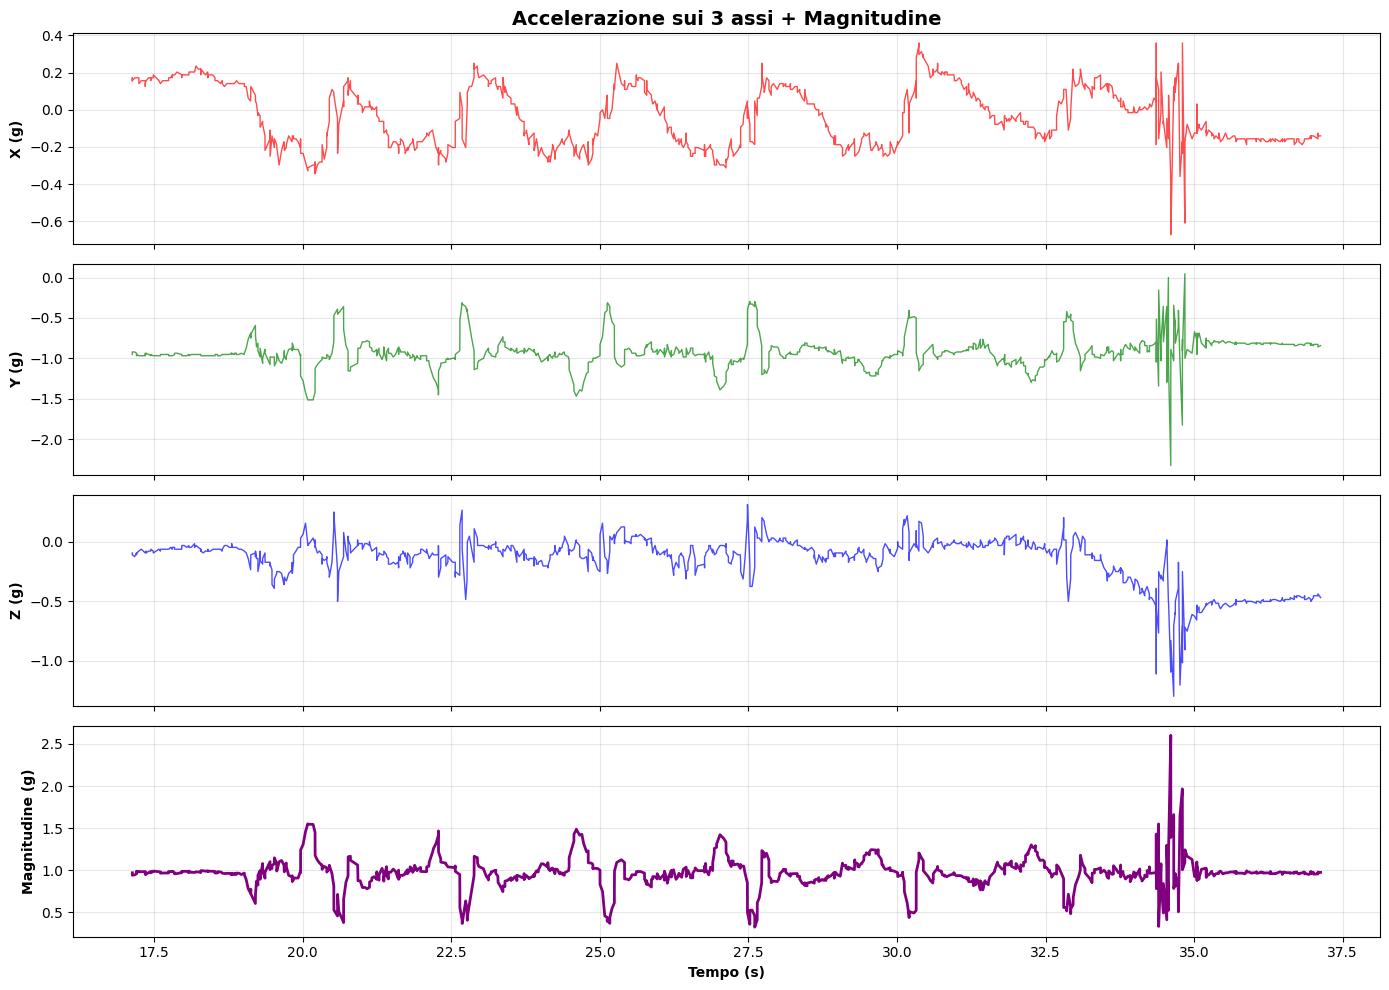

In [3]:
# Plot dei dati grezzi
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['X (g)'], 'r-', alpha=0.7, linewidth=1)
axes[0].set_ylabel('X (g)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Accelerazione sui 3 assi + Magnitudine', fontsize=14, fontweight='bold')

axes[1].plot(df['Timestamp'], df['Y (g)'], 'g-', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Y (g)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Timestamp'], df['Z (g)'], 'b-', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Z (g)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Timestamp'], df['Magnitude (g)'], 'purple', linewidth=2)
axes[3].set_ylabel('Magnitudine (g)', fontweight='bold')
axes[3].set_xlabel('Tempo (s)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Smoothing e Preprocessing

In [4]:
# Applica smoothing gaussiano per ridurre il rumore
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sigma = 2  # Parametro di smoothing

df['X_smooth'] = gaussian_filter1d(df['X (g)'], sigma=sigma)
df['Y_smooth'] = gaussian_filter1d(df['Y (g)'], sigma=sigma)
df['Z_smooth'] = gaussian_filter1d(df['Z (g)'], sigma=sigma)
df['Mag_smooth'] = gaussian_filter1d(df['Magnitude (g)'], sigma=sigma)

# Calcola la derivata (velocità) della magnitudine per identificare cambiamenti
df['Mag_velocity'] = np.gradient(df['Mag_smooth'], df['Timestamp'])
df['Mag_velocity_smooth'] = gaussian_filter1d(df['Mag_velocity'], sigma=sigma)

print("✅ Smoothing applicato")

✅ Smoothing applicato


## 5. Analisi Baseline e Soglie

Per la bench press, la baseline rappresenta la **barra in lockout** (posizione di partenza/riposo in alto).
Il movimento è **identico allo squat**: si parte dalla posizione alta e si scende a caricare.

**Pattern del movimento:**
1. **Baseline/Lockout** - Posizione di partenza in alto, stabile (~0.97g)
2. **Fase eccentrica** - Discesa controllata verso il petto, magnitudine scende (può arrivare a ~0.74g)
3. **Chest touch/Bottom** - Tocco al petto, punto più basso

4. **Fase concentrica** - Spinta esplosiva verso l'alto, accelerazione positiva, magnitudine sale sopra 1.0g⚠️ **Nota sul rebound**: Dopo il picco concentrico si può vedere un secondo minimo sul grafico - questo è il **rebound dell'accelerometro**, non un movimento reale della barra!

5. **Ritorno lockout** - Ritorno alla posizione di partenza in alto

In [5]:
# Analisi Magnitude con Soglie per Bench Press

mag = df['Mag_smooth'].values
timestamps = df['Timestamp'].values

print("🔍 ANALISI MAGNITUDE - BENCH PRESS")
print("=" * 80)

# Per bench press, baseline è la posizione di lockout (primi campioni stabili in alto)
baseline_samples = int(len(mag) * 0.2)
baseline_value = np.median(mag[:baseline_samples])

# Soglie per bench press (movimento IDENTICO allo squat: parte da alto e scende)
threshold_percent = 0.05  # 5% della baseline
upper_threshold = baseline_value + (baseline_value * threshold_percent)
lower_threshold = baseline_value - (baseline_value * threshold_percent)

print(f"📊 Baseline (barra in lockout/alto): {baseline_value:.3f}g")
print(f"📊 Soglia superiore (+5%): {upper_threshold:.3f}g")
print(f"📊 Soglia inferiore (-5%): {lower_threshold:.3f}g")

# Trova quando le soglie vengono rotte
upper_breaks = np.where(mag > upper_threshold)[0]
lower_breaks = np.where(mag < lower_threshold)[0]

print(f"\n🔴 Soglia superiore rotta in {len(upper_breaks)} punti (fase concentrica - spinta)")
if len(upper_breaks) > 0:
    print(f"   Primo break: t={timestamps[upper_breaks[0]]:.2f}s (Mag={mag[upper_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[upper_breaks[-1]]:.2f}s (Mag={mag[upper_breaks[-1]]:.3f}g)")

print(f"\n🟢 Soglia inferiore rotta in {len(lower_breaks)} punti (discesa eccentrica)")
if len(lower_breaks) > 0:
    print(f"   Primo break: t={timestamps[lower_breaks[0]]:.2f}s (Mag={mag[lower_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[lower_breaks[-1]]:.2f}s (Mag={mag[lower_breaks[-1]]:.3f}g)")

print("=" * 80)

🔍 ANALISI MAGNITUDE - BENCH PRESS
📊 Baseline (barra in lockout/alto): 0.978g
📊 Soglia superiore (+5%): 1.027g
📊 Soglia inferiore (-5%): 0.929g

🔴 Soglia superiore rotta in 240 punti (fase concentrica - spinta)
   Primo break: t=19.45s (Mag=1.029g)
   Ultimo break: t=35.01s (Mag=1.053g)

🟢 Soglia inferiore rotta in 249 punti (discesa eccentrica)
   Primo break: t=19.02s (Mag=0.901g)
   Ultimo break: t=34.69s (Mag=0.925g)


## 6. Visualizzazione con Marker delle Soglie

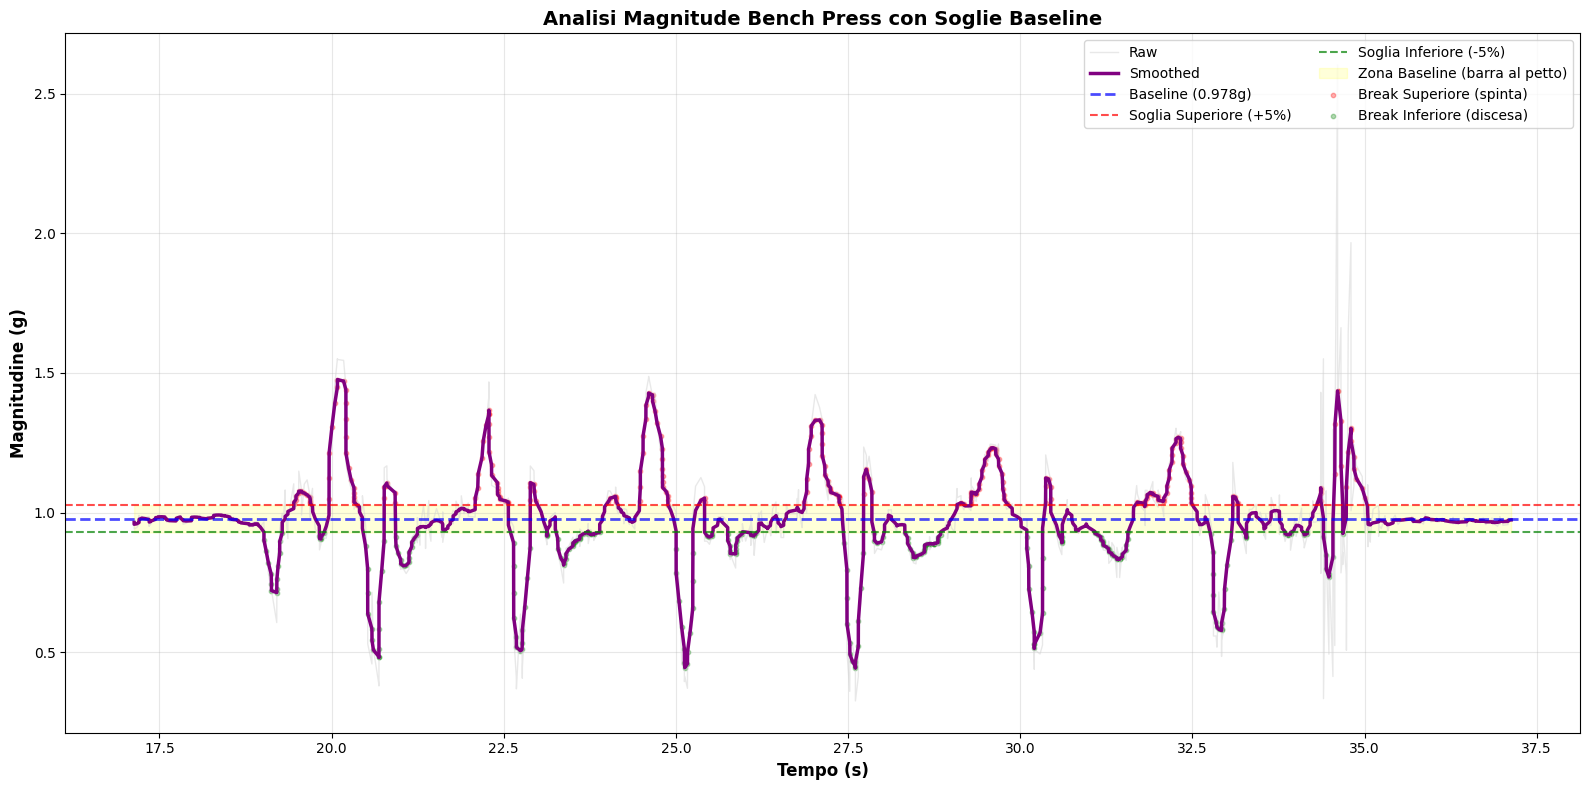

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot magnitudine
ax.plot(df['Timestamp'], df['Magnitude (g)'], 'lightgray', alpha=0.5, linewidth=1, label='Raw')
ax.plot(df['Timestamp'], df['Mag_smooth'], 'purple', linewidth=2.5, label='Smoothed')

# Linee delle soglie
ax.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_value:.3f}g)', alpha=0.7)
ax.axhline(y=upper_threshold, color='red', linestyle='--', linewidth=1.5, label=f'Soglia Superiore (+5%)', alpha=0.7)
ax.axhline(y=lower_threshold, color='green', linestyle='--', linewidth=1.5, label=f'Soglia Inferiore (-5%)', alpha=0.7)

# Zona baseline (fill between)
ax.fill_between(df['Timestamp'], lower_threshold, upper_threshold, color='yellow', alpha=0.15, label='Zona Baseline (barra al petto)')

# Evidenzia i punti dove le soglie vengono rotte
if len(upper_breaks) > 0:
    ax.scatter(timestamps[upper_breaks], mag[upper_breaks], color='red', s=10, alpha=0.3, label='Break Superiore (spinta)')

if len(lower_breaks) > 0:
    ax.scatter(timestamps[lower_breaks], mag[lower_breaks], color='green', s=10, alpha=0.3, label='Break Inferiore (discesa)')

ax.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
ax.set_title('Analisi Magnitude Bench Press con Soglie Baseline', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

## 7. Rilevamento Ripetizioni con Pattern Matching

Algoritmo basato su **sequenze di accelerazione** - pattern identico allo squat:

**Sequenza completa di una ripetizione:**
1. **LOCKOUT (baseline)** - Partenza in alto, stabile
2. **FASE ECCENTRICA** - Discesa controllata verso il petto (mag scende sotto baseline)
3. **CHEST TOUCH (bottom)** - Tocco al petto, punto più basso
4. **FASE CONCENTRICA (spinta)** ← qui calcoliamo VBT - Spinta esplosiva (mag sale sopra 1.0g)
5. **PICCO CONCENTRICO** - Massima accelerazione durante la spinta
6. **REBOUND** - ⚠️ Oscillazione accelerometro (NON movimento reale!)

7. **RITORNO LOCKOUT** - Ritorno alla posizione alta di partenzaL'algoritmo cerca la sequenza: LOCKOUT → DISCESA → CHEST TOUCH → SPINTA → LOCKOUT


In [7]:
"""
PATTERN MATCHING con VBT (Velocity Based Training) per BENCH PRESS
Rilevamento ripetizioni tramite transizioni di stato + calcolo metriche VBT avanzate
"""

# Configura parametri per bench press
BASELINE_ZONE = 0.08  # ±8% variazione = stato BASE
MIN_REP_DURATION = 0.5  # secondi
MAX_REP_DURATION = 4.0  # secondi
REFRACTORY_PERIOD = 0.8  # secondi tra ripetizioni
PEAK_PROMINENCE = 0.15  # Prominenza minima dei picchi

# Calcola baseline (barra in lockout - posizione alta di partenza)
baseline_samples = 30
baseline_value = np.median(mag[:baseline_samples])
baseline_upper = baseline_value * (1 + BASELINE_ZONE)
baseline_lower = baseline_value * (1 - BASELINE_ZONE)

print(f"📊 BASELINE ANALYSIS - BENCH PRESS")
print(f"   Baseline (barra in lockout/alto): {baseline_value:.3f}g")
print(f"   Upper threshold (+{BASELINE_ZONE*100:.0f}%): {baseline_upper:.3f}g")
print(f"   Lower threshold (-{BASELINE_ZONE*100:.0f}%): {baseline_lower:.3f}g")
print("=" * 90)

# Classifica samples in stati
# ABOVE = picco durante spinta, BASE = lockout, BELOW = discesa eccentrica/chest touch
signal_state = np.where(mag > baseline_upper, 1,  # ABOVE
                        np.where(mag < baseline_lower, -1,  # BELOW
                                 0))  # BASE

# Trova transizioni di stato
state_changes = []
for i in range(1, len(signal_state)):
    if signal_state[i] != signal_state[i-1]:
        state_changes.append({
            'idx': i,
            'time': timestamps[i],
            'from_state': signal_state[i-1],
            'to_state': signal_state[i],
            'mag': mag[i]
        })

print(f"🔄 State transitions detected: {len(state_changes)}")

# Pattern Matching SEMPLIFICATO per BENCH PRESS con FINESTRA TEMPORALE:
# LOGICA ROBUSTA:
# 1. Rompe baseline verso BASSO → Apre finestra di 2 secondi
# 2. Cerca PICCO massimo nella finestra di 2 secondi
# 3. Cerca minimo locale (baseline relativa) PRIMA del picco → chest touch
# 4. Chiude finestra
valid_reps = []
last_rep_end_time = -REFRACTORY_PERIOD
WINDOW_DURATION = 2.0  # secondi - durata finestra dopo rottura baseline

for i in range(len(state_changes) - 1):
    # APRE FINESTRA: esce da BASE verso BELOW (rottura baseline verso basso)
    if state_changes[i]['from_state'] == 0 and state_changes[i]['to_state'] == -1:
        window_start_idx = state_changes[i]['idx']
        window_start_time = state_changes[i]['time']
        
        # Applica refractory period
        if window_start_time - last_rep_end_time < REFRACTORY_PERIOD:
            continue
        
        # Definisci fine finestra (2 secondi dopo)
        window_end_time = window_start_time + WINDOW_DURATION
        window_end_idx = np.searchsorted(timestamps, window_end_time)
        window_end_idx = min(window_end_idx, len(mag) - 1)
        
        # Estrai segmento della finestra
        window_segment = mag[window_start_idx:window_end_idx+1]
        window_times = timestamps[window_start_idx:window_end_idx+1]
        
        if len(window_segment) < 20:  # Minimo 20 samples
            continue
        
        # STEP 2: Cerca PICCO massimo nella finestra
        concentric_peak_relative = np.argmax(window_segment)
        concentric_peak_idx = window_start_idx + concentric_peak_relative
        
        # Verifica che il picco sia effettivamente alto (sopra baseline_upper)
        if mag[concentric_peak_idx] <= baseline_upper:
            continue
        
        # STEP 3: Cerca minimo locale (chest touch) PRIMA del picco
        # Segmento da window_start fino al picco
        pre_peak_segment = window_segment[:concentric_peak_relative+1]
        
        if len(pre_peak_segment) < 2:
            continue
        
        # Trova minimo locale (chest touch) - FILTRO per spike sotto 0.6g
        MIN_VALID_CHEST = 0.6  # g - sotto questo sono artefatti accelerometro
        valid_mask = pre_peak_segment >= MIN_VALID_CHEST
        
        if np.any(valid_mask):
            # Trova minimo tra i valori validi
            valid_indices = np.where(valid_mask)[0]
            chest_touch_relative = valid_indices[np.argmin(pre_peak_segment[valid_mask])]
        else:
            # Fallback: usa minimo assoluto
            chest_touch_relative = np.argmin(pre_peak_segment)
        
        chest_touch_idx = window_start_idx + chest_touch_relative
        
        # VBT START = chest touch (inizio vera spinta concentrica)
        rep_start_idx = chest_touch_idx
        rep_start_time = timestamps[chest_touch_idx]
        
        # END = quando ritorna vicino a baseline dopo il picco
        # Cerca primo ritorno verso baseline dopo il picco
        post_peak_segment = window_segment[concentric_peak_relative:]
        post_peak_times = window_times[concentric_peak_relative:]
        
        # Trova quando torna sotto baseline_upper + margine
        baseline_return_mask = post_peak_segment < (baseline_upper + 0.05)
        
        if np.any(baseline_return_mask):
            baseline_return_relative = np.where(baseline_return_mask)[0][0]
            rep_end_idx = concentric_peak_idx + baseline_return_relative
        else:
            # Se non torna a baseline nella finestra, usa fine finestra
            rep_end_idx = window_end_idx
        
        rep_end_time = timestamps[rep_end_idx]
        rep_duration = rep_end_time - window_start_time
        concentric_duration = rep_end_time - rep_start_time
        
        # Valida durata
        if MIN_REP_DURATION <= rep_duration <= MAX_REP_DURATION:
            # Salva ripetizione valida
            rep = {
                'rep_num': len(valid_reps) + 1,
                'window_start_idx': window_start_idx,     # Rottura baseline verso basso
                'chest_touch_idx': chest_touch_idx,       # Minimo prima del picco
                'start_idx': chest_touch_idx,             # START VBT = chest touch
                'concentric_peak_idx': concentric_peak_idx,
                'end_idx': rep_end_idx,
                'window_start_time': window_start_time,
                'chest_touch_time': timestamps[chest_touch_idx],
                'start_time': rep_start_time,
                'end_time': rep_end_time,
                'concentric_peak_time': timestamps[concentric_peak_idx],
                'duration': rep_duration,
                'concentric_duration': concentric_duration,
                'mag_window_start': mag[window_start_idx],
                'mag_chest_touch': mag[chest_touch_idx],
                'mag_start': mag[chest_touch_idx],
                'mag_peak': mag[concentric_peak_idx],
                'mag_end': mag[rep_end_idx]
            }
            valid_reps.append(rep)
            last_rep_end_time = rep_end_time

print(f"\n✅ Valid repetitions detected: {len(valid_reps)}")
print("=" * 90)

# CALCOLO METRICHE VBT per ogni ripetizione
reps_with_metrics = []  # Solo le reps con metriche VBT valide

if len(valid_reps) > 0:
    for rep in valid_reps:
        # Estrai fase concentrica (start → peak)
        start_idx = rep['start_idx']
        concentric_peak_idx = rep['concentric_peak_idx']
        
        if concentric_peak_idx <= start_idx:
            print(f"⚠️  Rep {rep['rep_num']}: Invalid concentric phase (peak before start)")
            continue
        
        mag_concentric = mag[start_idx:concentric_peak_idx+1]
        time_concentric = timestamps[start_idx:concentric_peak_idx+1]
        
        if len(mag_concentric) < 2:
            print(f"⚠️  Rep {rep['rep_num']}: Too few samples in concentric phase")
            continue
        
        # GRAVITY COMPENSATION - sottrai 1.0g per accelerazione netta
        mag_accel_net = (mag_concentric - 1.0) * 9.81  # m/s²
        
        print(f"\n🔍 DEBUG Rep {rep['rep_num']}:")
        print(f"   Window: {rep['window_start_time']:.2f}s → Chest: {rep['chest_touch_time']:.2f}s → VBT START: {rep['start_time']:.2f}s")
        print(f"   Mag range: {mag_concentric.min():.3f}g to {mag_concentric.max():.3f}g")
        print(f"   Accel net range: {mag_accel_net.min():.3f} to {mag_accel_net.max():.3f} m/s²")
        
        # Integrazione velocità: v(t) = v(t-1) + a(t) * dt, con v(0) = 0 all'inizio
        velocity = np.zeros(len(mag_accel_net))
        displacement = np.zeros(len(mag_accel_net))
        for k in range(1, len(mag_accel_net)):
            dt = time_concentric[k] - time_concentric[k-1]
            velocity[k] = velocity[k-1] + mag_accel_net[k] * dt
            displacement[k] = displacement[k-1] + velocity[k] * dt
        
        print(f"   Velocity range: {velocity.min():.3f} to {velocity.max():.3f} m/s")
        
        # Calcola propulsive mask PRIMA (per usarla dopo)
        propulsive_mask = mag_accel_net > 0
        
        # Metriche VBT di base
        positive_velocity = velocity[velocity > 0]
        if len(positive_velocity) > 0:
            mean_velocity = np.mean(positive_velocity)
            peak_velocity = np.max(velocity)
            # Mean Propulsive Velocity (MPV) - solo dove accelerazione è positiva
            if np.any(propulsive_mask):
                mean_propulsive_velocity = np.mean(velocity[propulsive_mask])
            else:
                mean_propulsive_velocity = 0.0
        else:
            mean_velocity = 0.0
            peak_velocity = 0.0
            mean_propulsive_velocity = 0.0
        
        # Time to Peak Velocity
        peak_vel_idx = np.argmax(velocity)
        time_to_peak_velocity = time_concentric[peak_vel_idx] - time_concentric[0]
        
        # ROM (Range of Motion) - displacement totale nella fase concentrica
        concentric_displacement = displacement[-1]
        
        # Calcolo potenza (P = m * a * v)
        MASS = 1.0  # kg (placeholder - da sostituire con massa reale)
        power = MASS * mag_accel_net * velocity  # Watt
        mean_power = np.mean(power[power > 0]) if np.any(power > 0) else 0.0
        peak_power = np.max(power)
        
        # Mean Propulsive Power - usa la stessa maschera propulsiva
        if np.any(propulsive_mask):
            mean_propulsive_power = np.mean(power[propulsive_mask])
        else:
            mean_propulsive_power = 0.0
        
        # Salva tutte le metriche
        rep['mean_velocity'] = mean_velocity
        rep['peak_velocity'] = peak_velocity
        rep['mean_propulsive_velocity'] = mean_propulsive_velocity
        rep['time_to_peak_velocity'] = time_to_peak_velocity
        rep['concentric_displacement'] = concentric_displacement
        rep['mean_power'] = mean_power
        rep['peak_power'] = peak_power
        rep['mean_propulsive_power'] = mean_propulsive_power
        rep['concentric_duration'] = rep['concentric_peak_time'] - rep['start_time']
        rep['eccentric_duration'] = rep['end_time'] - rep['concentric_peak_time']
        rep['time_under_tension'] = rep['duration']
        
        # Aggiungi alla lista delle reps valide con metriche
        reps_with_metrics.append(rep)
        
        print(f"   ⏱️  Sequenza: WINDOW {rep['window_start_time']:.2f}s → CHEST {rep['chest_touch_time']:.2f}s → VBT START {rep['start_time']:.2f}s → PEAK {rep['concentric_peak_time']:.2f}s → END {rep['end_time']:.2f}s")
        print(f"   📈 Magnitudine: {rep['mag_chest_touch']:.3f}g (chest) → {rep['mag_start']:.3f}g (vbt start) → {rep['mag_peak']:.3f}g (peak) → {rep['mag_end']:.3f}g (end)")
        print(f"   🚀 Mean Velocity: {rep['mean_velocity']:.3f} m/s | MPV: {rep['mean_propulsive_velocity']:.3f} m/s")
        print(f"   ⚡ Peak Velocity: {rep['peak_velocity']:.3f} m/s | Time to Peak: {rep['time_to_peak_velocity']:.3f}s")
        print(f"   💪 Mean Power: {rep['mean_power']:.2f} W | Peak Power: {rep['peak_power']:.2f} W | MPP: {rep['mean_propulsive_power']:.2f} W")
        print(f"   📏 ROM (Concentric): {rep['concentric_displacement']:.3f} m")
    
    print("=" * 90)
    
    # Sostituisci valid_reps con reps_with_metrics per le statistiche
    valid_reps = reps_with_metrics
    
    # Statistiche aggregate e Velocity Loss
    if len(valid_reps) > 1:
        mean_vels = [r['mean_velocity'] for r in valid_reps]
        peak_vels = [r['peak_velocity'] for r in valid_reps]
        mpvs = [r['mean_propulsive_velocity'] for r in valid_reps]
        mean_powers = [r['mean_power'] for r in valid_reps]
        peak_powers = [r['peak_power'] for r in valid_reps]
        roms = [r['concentric_displacement'] for r in valid_reps]
        tuts = [r['time_under_tension'] for r in valid_reps]
        
        # Velocity Loss (VL%) - perdita tra prima e ultima ripetizione
        velocity_loss_percent = ((mean_vels[0] - mean_vels[-1]) / mean_vels[0]) * 100 if mean_vels[0] > 0 else 0.0
        
        print(f"\n📈 STATISTICHE AGGREGATE ({len(valid_reps)} ripetizioni)")
        print(f"   Mean Velocity: {np.mean(mean_vels):.3f} m/s (±{np.std(mean_vels):.3f})")
        print(f"   Peak Velocity: {np.mean(peak_vels):.3f} m/s (±{np.std(peak_vels):.3f})")
        print(f"   Mean Propulsive Velocity: {np.mean(mpvs):.3f} m/s (±{np.std(mpvs):.3f})")
        print(f"   Mean Power: {np.mean(mean_powers):.2f} W (±{np.std(mean_powers):.2f})")
        print(f"   Peak Power: {np.mean(peak_powers):.2f} W (±{np.std(peak_powers):.2f})")
        print(f"   ROM (Concentric): {np.mean(roms):.3f} m (±{np.std(roms):.3f})")
        print(f"   Time Under Tension: {np.mean(tuts):.2f}s (±{np.std(tuts):.2f})")
        print(f"\n📉 VELOCITY LOSS: {velocity_loss_percent:.1f}% (Rep 1 → Rep {len(valid_reps)})")
        if velocity_loss_percent > 20:
            print(f"   ⚠️  Alta fatica rilevata (VL > 20%)")
        elif velocity_loss_percent > 10:
            print(f"   ⚡ Fatica moderata (VL 10-20%)")
        else:
            print(f"   ✅ Fatica minima (VL < 10%)")
        print("=" * 90)
else:
    print("⚠️ Nessuna ripetizione valida rilevata")

📊 BASELINE ANALYSIS - BENCH PRESS
   Baseline (barra in lockout/alto): 0.974g
   Upper threshold (+8%): 1.052g
   Lower threshold (-8%): 0.896g
🔄 State transitions detected: 64

✅ Valid repetitions detected: 5

🔍 DEBUG Rep 1:
   Window: 19.05s → Chest: 19.20s → VBT START: 19.20s
   Mag range: 0.713g to 1.476g
   Accel net range: -2.812 to 4.670 m/s²
   Velocity range: -0.109 to 0.407 m/s
   ⏱️  Sequenza: WINDOW 19.05s → CHEST 19.20s → VBT START 19.20s → PEAK 20.09s → END 20.33s
   📈 Magnitudine: 0.713g (chest) → 0.713g (vbt start) → 1.476g (peak) → 1.088g (end)
   🚀 Mean Velocity: 0.085 m/s | MPV: 0.020 m/s
   ⚡ Peak Velocity: 0.407 m/s | Time to Peak: 0.882s
   💪 Mean Power: 0.21 W | Peak Power: 1.90 W | MPP: 0.17 W
   📏 ROM (Concentric): 0.004 m

🔍 DEBUG Rep 2:
   Window: 22.64s → Chest: 22.64s → VBT START: 22.64s
   Mag range: 0.505g to 1.428g
   Accel net range: -4.853 to 4.197 m/s²
   Velocity range: -1.522 to 0.000 m/s
   ⏱️  Sequenza: WINDOW 22.64s → CHEST 22.64s → VBT START 22.

## 8. Visualizzazione Ripetizioni Rilevate con VBT

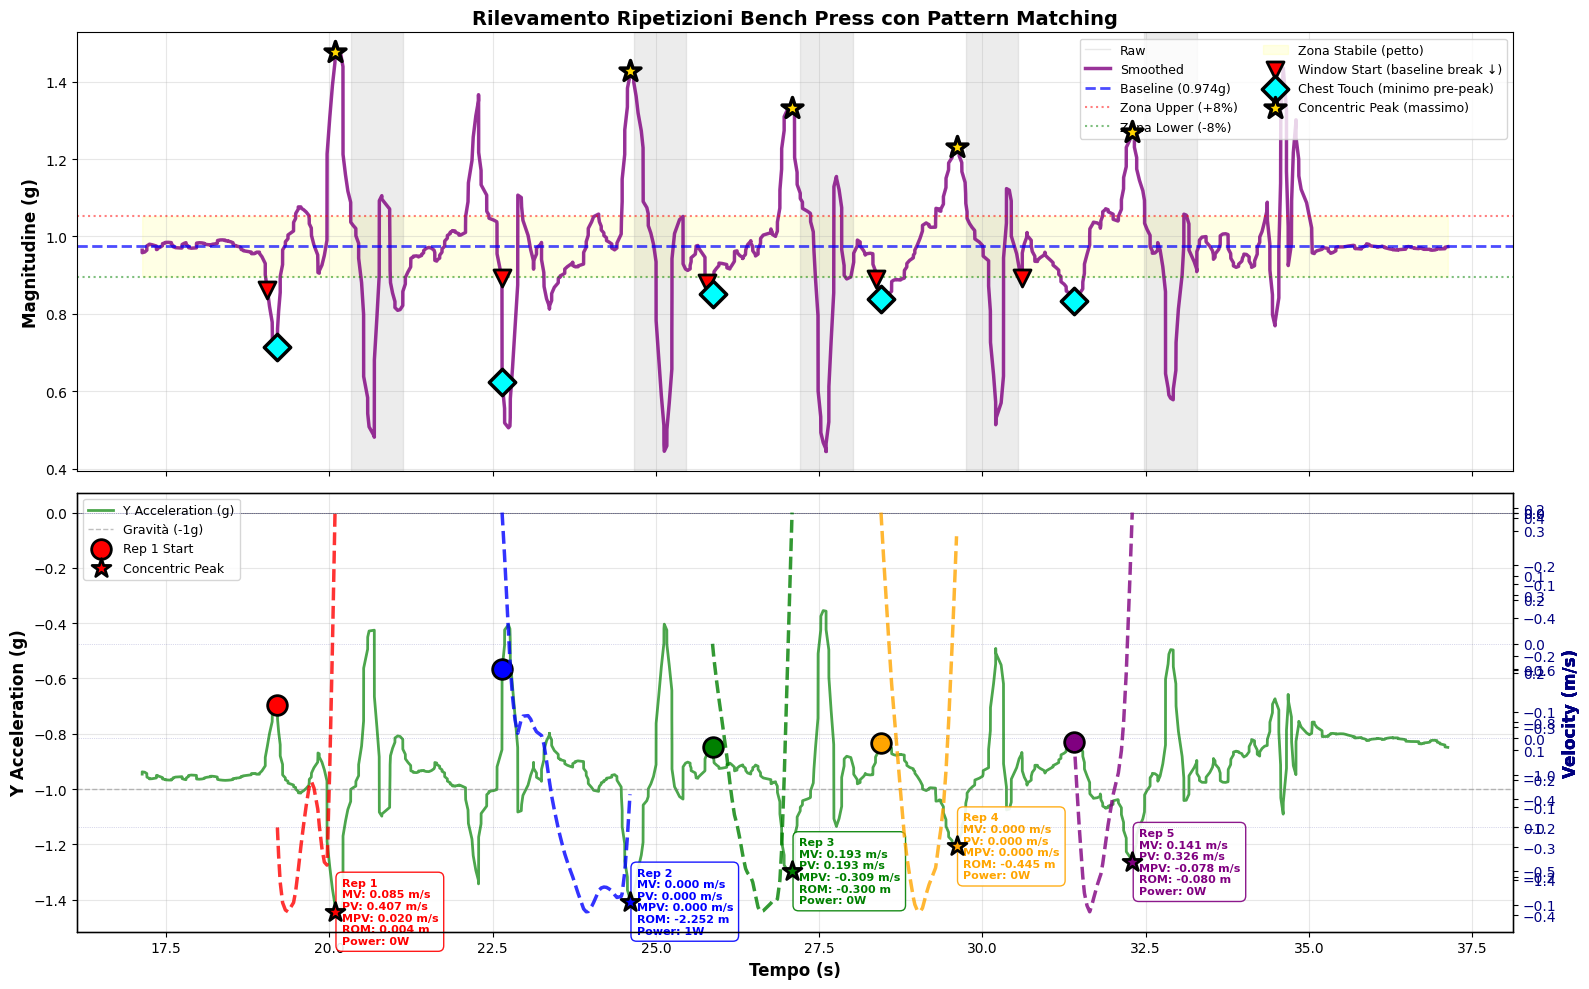

✅ Visualizzazione completata


In [8]:
if len(valid_reps) > 0:
    # Estrai Y acceleration smoothed per il plot
    y_acc = df['Y_smooth'].values
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # SUBPLOT 1: Magnitudine con marker delle fasi
    ax1 = axes[0]
    ax1.plot(timestamps, mag, 'lightgray', alpha=0.5, linewidth=1, label='Raw')
    ax1.plot(timestamps, mag, 'purple', linewidth=2.5, label='Smoothed', alpha=0.8)
    
    # Zone baseline (pattern matching)
    ax1.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline ({baseline_value:.3f}g)', alpha=0.7)
    ax1.axhline(y=baseline_upper, color='red', linestyle=':', linewidth=1.5, label=f'Zona Upper (+{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.axhline(y=baseline_lower, color='green', linestyle=':', linewidth=1.5, label=f'Zona Lower (-{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.fill_between(timestamps, baseline_lower, baseline_upper, color='yellow', alpha=0.1, label='Zona Stabile (petto)')
    
    # Marker per ogni ripetizione
    colors_rep = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # MARKER SEMPLIFICATI - Solo quelli con logica robusta:
        # 1. Window Start (rottura baseline verso basso)
        # 2. Chest Touch (minimo prima del picco)
        # 3. Concentric Peak (massimo nella finestra di 2s)
        ax1.scatter(rep['window_start_time'], rep['mag_window_start'], s=150, marker='v', color='red', 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='Window Start (baseline break ↓)' if i == 0 else None)
        ax1.scatter(rep['chest_touch_time'], rep['mag_chest_touch'], s=180, marker='D', color='cyan', 
                   edgecolors='black', linewidths=2.5, zorder=11,
                   label='Chest Touch (minimo pre-peak)' if i == 0 else None)
        ax1.scatter(rep['concentric_peak_time'], rep['mag_peak'], s=250, marker='*', 
                   color='gold', edgecolors='black', linewidths=2.5, zorder=12,
                   label='Concentric Peak (massimo)' if i == 0 else None)
        
        # Zona refrattaria dopo ogni rep
        refractory_end = rep['end_time'] + REFRACTORY_PERIOD
        ax1.axvspan(rep['end_time'], min(refractory_end, timestamps[-1]), 
                   color='gray', alpha=0.15, zorder=1)
    
    ax1.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
    ax1.set_title('Rilevamento Ripetizioni Bench Press con Pattern Matching', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=9, ncol=2)
    
    # SUBPLOT 2: Accelerazione Y con velocità integrata
    ax2 = axes[1]
    ax2.plot(timestamps, y_acc, 'green', linewidth=2, alpha=0.7, label='Y Acceleration (g)')
    ax2.axhline(y=-1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Gravità (-1g)')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Plot velocità per ogni ripetizione
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Ricostruisci velocità per il plot usando magnitudine
        concentric_slice = slice(rep['start_idx'], rep['concentric_peak_idx'] + 1)
        mag_concentric = mag[concentric_slice]
        time_concentric = timestamps[concentric_slice]
        mag_accel_net = (mag_concentric - 1.0) * 9.81
        
        velocity_plot = np.zeros(len(mag_accel_net))
        for j in range(1, len(velocity_plot)):
            dt_step = time_concentric[j] - time_concentric[j-1]
            velocity_plot[j] = velocity_plot[j-1] + mag_accel_net[j] * dt_step
        
        # Plot su asse secondario
        ax2_vel = ax2.twinx()
        ax2_vel.plot(time_concentric, velocity_plot, color=color, linewidth=2.5, 
                    linestyle='--', alpha=0.8, label=f"Rep {rep['rep_num']} Velocity")
        ax2_vel.set_ylabel('Velocity (m/s)', fontweight='bold', fontsize=12, color='navy')
        ax2_vel.tick_params(axis='y', labelcolor='navy')
        ax2_vel.axhline(y=0, color='navy', linestyle=':', linewidth=0.5, alpha=0.3)
        
        # Marker start e picco concentrico
        ax2.scatter(rep['start_time'], y_acc[rep['start_idx']], s=200, marker='o', 
                   color=color, edgecolors='black', linewidths=2, zorder=10, 
                   label=f"Rep {rep['rep_num']} Start" if i == 0 else None)
        ax2.scatter(rep['concentric_peak_time'], y_acc[rep['concentric_peak_idx']], s=200, marker='*', 
                   color=color, edgecolors='black', linewidths=2, zorder=10,
                   label='Concentric Peak' if i == 0 else None)
        
        # Aggiungi testo con metriche VBT complete vicino al picco concentrico
        text_x = rep['concentric_peak_time'] + 0.1
        text_y = y_acc[rep['concentric_peak_idx']]
        metrics_text = (f"Rep {rep['rep_num']}\n"
                       f"MV: {rep['mean_velocity']:.3f} m/s\n"
                       f"PV: {rep['peak_velocity']:.3f} m/s\n"
                       f"MPV: {rep['mean_propulsive_velocity']:.3f} m/s\n"
                       f"ROM: {rep['concentric_displacement']:.3f} m\n"
                       f"Power: {rep['mean_power']:.0f}W")
        ax2.text(text_x, text_y, metrics_text,
                fontsize=8, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color, alpha=0.9),
                verticalalignment='center')
    
    ax2.set_ylabel('Y Acceleration (g)', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione completata")
else:
    print("⚠️ Nessuna ripetizione da visualizzare")

## 9. Confronto tra Ripetizioni - Analisi Velocità

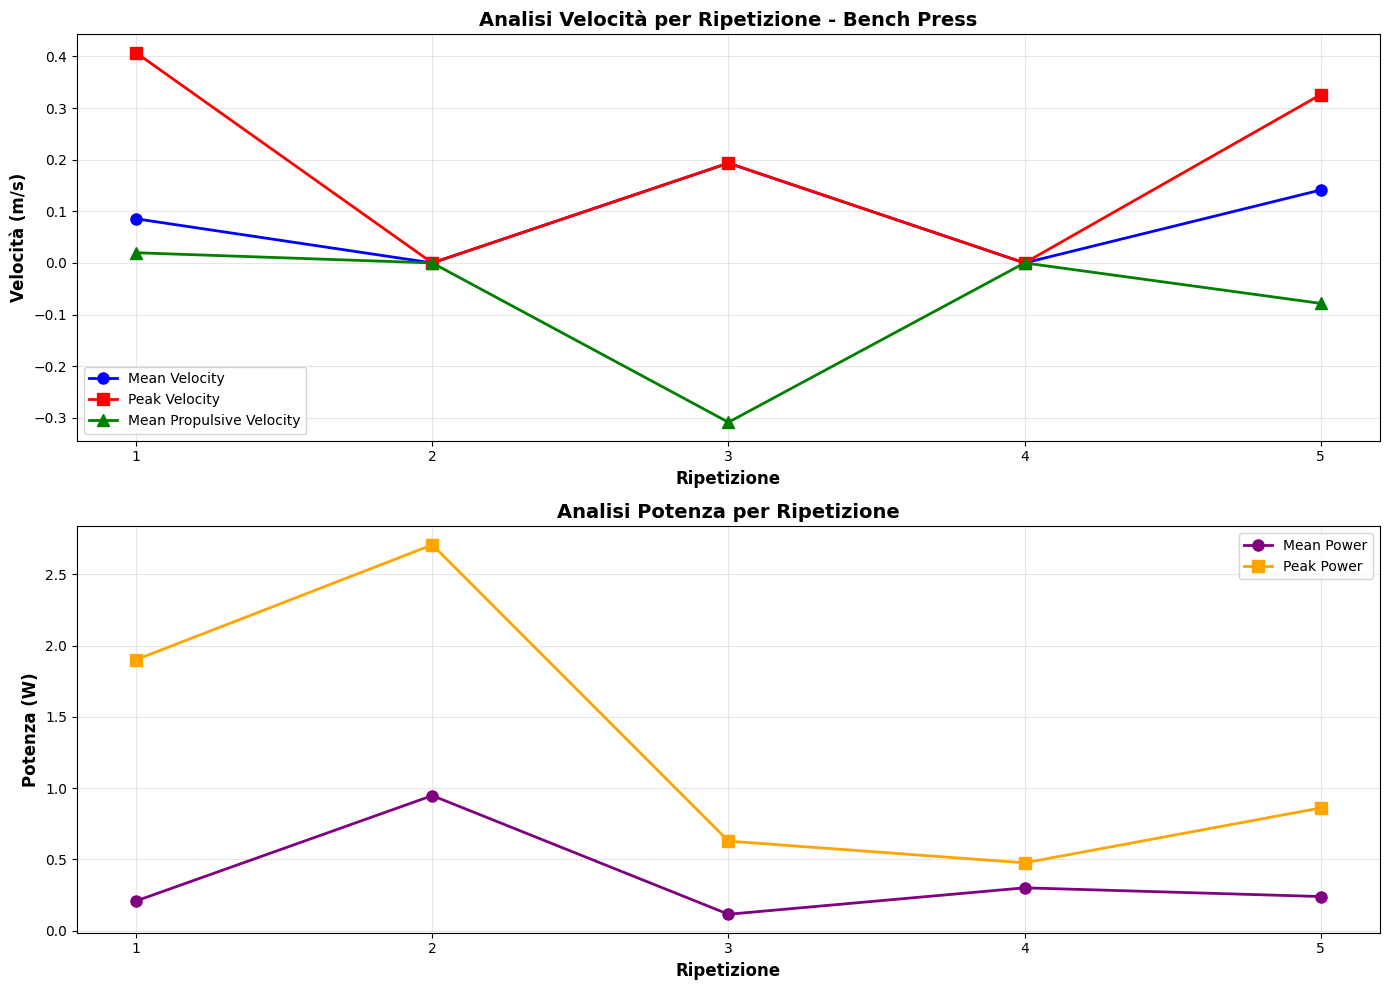

✅ Confronto ripetizioni completato


In [9]:
if len(valid_reps) > 1:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Mean Velocity e Peak Velocity per ogni rep
    rep_nums = [r['rep_num'] for r in valid_reps]
    mean_vels = [r['mean_velocity'] for r in valid_reps]
    peak_vels = [r['peak_velocity'] for r in valid_reps]
    mpvs = [r['mean_propulsive_velocity'] for r in valid_reps]
    
    ax1 = axes[0]
    ax1.plot(rep_nums, mean_vels, 'o-', linewidth=2, markersize=8, label='Mean Velocity', color='blue')
    ax1.plot(rep_nums, peak_vels, 's-', linewidth=2, markersize=8, label='Peak Velocity', color='red')
    ax1.plot(rep_nums, mpvs, '^-', linewidth=2, markersize=8, label='Mean Propulsive Velocity', color='green')
    ax1.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Velocità (m/s)', fontweight='bold', fontsize=12)
    ax1.set_title('Analisi Velocità per Ripetizione - Bench Press', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xticks(rep_nums)
    
    # Plot 2: Power per ogni rep
    mean_powers = [r['mean_power'] for r in valid_reps]
    peak_powers = [r['peak_power'] for r in valid_reps]
    
    ax2 = axes[1]
    ax2.plot(rep_nums, mean_powers, 'o-', linewidth=2, markersize=8, label='Mean Power', color='purple')
    ax2.plot(rep_nums, peak_powers, 's-', linewidth=2, markersize=8, label='Peak Power', color='orange')
    ax2.set_xlabel('Ripetizione', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Potenza (W)', fontweight='bold', fontsize=12)
    ax2.set_title('Analisi Potenza per Ripetizione', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xticks(rep_nums)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Confronto ripetizioni completato")
else:
    print("⚠️ Servono almeno 2 ripetizioni per il confronto")

## 10. Riepilogo e Conclusioni

Questo notebook ha analizzato i dati dell'accelerometro durante l'esecuzione della **bench press** identificando le fasi del movimento:

### Fasi Identificate:
1. 🔵 **Baseline Start** - Barra al petto, posizione iniziale
2. 🚀 **Fase Concentrica** - Spinta esplosiva verso l'alto
3. ⭐ **Lockout** - Posizione superiore, massima estensione (concentric peak)
4. 📉 **Rebound Spike** - Oscillazione del sensore (effetto uguale e contrario al peak)
5. 🔻 **Fase Eccentrica** - Discesa controllata della barra
6. 🔵 **Baseline End** - Ritorno al petto

### Marker sui Grafici:
- **Triangoli giù** (▼) = Start (petto)
- **Stelle dorate** (★) = Concentric Peak (lockout)
- **Quadrati rossi** (■) = Rebound Spike (oscillazione accelerometro)
- **Triangoli su** (▲) = End (ritorno al petto)

### ⚠️ Nota sul Rebound Spike:
Il **rebound spike** (quadrati rossi) è un **artefatto del sensore**, non rappresenta un reale movimento della barra. Dopo il concentric peak, l'accelerometro registra un'oscillazione meccanica opposta dovuta all'inerzia del dispositivo. Questo picco NON dovrebbe essere usato per calcoli VBT, è solo un marker visivo per debug.

### Metriche VBT Calcolate:
✅ **Mean Velocity (MV)** - Velocità media nella fase concentrica  
✅ **Peak Velocity (PV)** - Velocità massima raggiunta  
✅ **Mean Propulsive Velocity (MPV)** - Velocità media nella fase propulsiva (accel > 0)  
✅ **Mean Power** - Potenza media  
✅ **Peak Power** - Potenza massima  
✅ **ROM** - Range of Motion (spostamento)  
✅ **Velocity Loss (VL%)** - Perdita di velocità tra prima e ultima ripetizione (indicatore di fatica)

### Analisi Completata:
✅ Identificazione automatica delle fasi della bench press  
✅ Marker visualizzati per ogni transizione di fase  
✅ Calcolo metriche VBT complete per ogni ripetizione  
✅ Statistiche aggregate e analisi del velocity loss  
✅ Confronto tra ripetizioni per monitorare la fatica